In [22]:
import pandas as pd
import talib as ta
import datetime as dt
import math
import numpy as np
import plotly.graph_objects as go

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from numpy.linalg import eig
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score,mean_absolute_error,precision_score,recall_score, f1_score


from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

import matplotlib.pyplot as plt
from matplotlib import style

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils.vis_utils import plot_model

In [2]:
import yfinance as yf

In [3]:
ticker = yf.Ticker('BTC-USD')
df = ticker.history(start="2017-01-02", end="2022-02-28")

In [4]:
df.reset_index(inplace=True)

In [5]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,0,0
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0,0
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0,0
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0,0
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,0,0
...,...,...,...,...,...,...,...,...
1879,2022-02-23,38285.281250,39122.394531,37201.816406,37296.570312,21849073843,0,0
1880,2022-02-24,37278.566406,38968.839844,34459.218750,38332.609375,46383802093,0,0
1881,2022-02-25,38333.746094,39630.324219,38111.343750,39214.218750,26545599159,0,0
1882,2022-02-26,39213.082031,40005.347656,38702.535156,39105.148438,17467554129,0,0


In [ ]:
ticker = yf.Ticker('BTC-USD')
googl = ticker.history(start="2017-01-02", end="2022-02-28")
# googl = get_historical_data('GOOGL', '2020-01-01')
googl

df.reset_index(inplace=True)

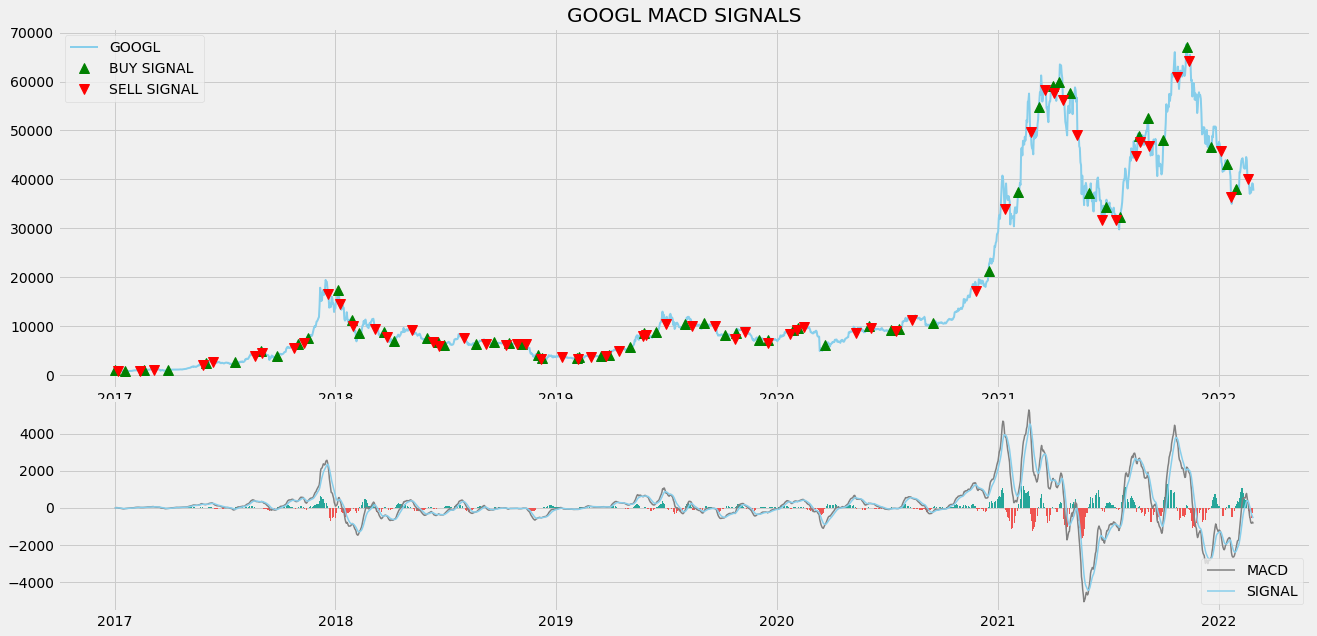

Profit gained from the MACD strategy by investing $100k in GOOGL : 3932105.69
Profit percentage of the MACD strategy : 3932%


KeyError: 'investment_returns'

In [104]:
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

# def get_historical_data(symbol, start_date = None):
#     api_key = open(r'api_key.txt')
#     api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
#     raw_df = requests.get(api_url).json()
#     df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
#     df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. Close': 'Close', '5. adjusted Close': 'adj Close', '6. volume': 'volume'})
#     for i in df.columns:
#         df[i] = df[i].astype(float)
#     df.index = pd.to_datetime(df.index)
#     df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
#     if start_date:
#         df = df[df.index >= start_date]
#     return df



def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

googl_macd = get_macd(googl['Close'], 26, 12, 9)
googl_macd

def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(googl['Close'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])

def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(googl['Close'], googl_macd)

ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(googl['Close'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
ax1.plot(googl.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(googl.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('GOOGL MACD SIGNALS')
ax2.plot(googl_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(googl_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(googl_macd)):
    if str(googl_macd['hist'][i])[0] == '-':
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(googl['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = googl_macd['macd']
signal = googl_macd['signal']
Close_price = googl['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(googl.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(googl.index)

frames = [Close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

googl_ret = pd.DataFrame(np.diff(googl['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(googl_ret)):
    try:
        returns = googl_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value/googl['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing $100k in GOOGL : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

def get_benchmark(start_date, investment_value):
    stock = yf.Ticker('BTC-USD')
    spy = ticker.history(start_date)['Close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[0])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('MACD Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))